# Companion notebook to EF's training on optimization with data uncertainty

Sander Vlot & Joaquim Gromicho, 2021

---
 > During this course we make use of Jupyter notebooks hosted by [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). 
 The usage of this platform is allowed by ORTEC for **educational and personal experimentation only**. May you consider using it for a project please consult the IT department.
 Notebooks deployed on `colab` require neither python nor other dependencies to be installed on your own machine, you only need a browser (preferably `chrome`) and you may also need a google account if you want to execute them. 
 
---

This notebook has been setup for `colab`. Check [the pyomo cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/) and in particular [the explanation on how to get pyomo and the solvers on colab](https://jckantor.github.io/ND-Pyomo-Cookbook/01.02-Running-Pyomo-on-Google-Colab.html).

May you want to use on your own python distribution, then you should care for  the installation of the required packages and subsidiary applications. 


In [ ]:
import sys
at_colab = "google.colab" in sys.modules

if at_colab:
    _=!pip install -q pyomo
    _=!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
    _=!unzip -o -q ipopt-linux64
    _=!apt-get install -y -q coinor-cbc
    _=!pip install -q cplex
    _=!pip install -q gurobipy
    _=!pip install -q xpress

In [ ]:
!pyomo help --solvers


Pyomo Solvers and Solver Managers
---------------------------------
Pyomo uses 'solver managers' to execute 'solvers' that perform
optimization and other forms of model analysis.  A solver directly
executes an optimizer, typically using an executable found on the
user's PATH environment.  Solver managers support a flexible mechanism
for asyncronously executing solvers either locally or remotely.  The
following solver managers are available in Pyomo:

    neos       Asynchronously execute solvers on the NEOS server
    serial     Synchronously execute solvers locally

If no solver manager is specified, Pyomo uses the serial solver
manager to execute solvers locally.  The neos solver manager is used
to execute solvers on the NEOS optimization server.


Serial Solver Interfaces
------------------------
The serial manager supports the following solver interfaces:

CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.
Version identifier: 

In [ ]:
import pyomo.environ as pyo
cbc    = pyo.SolverFactory('cbc')
ipopt  = pyo.SolverFactory('ipopt')
cplex  = pyo.SolverFactory('cplex_direct')
gurobi = pyo.SolverFactory('gurobi_direct')
xpress = pyo.SolverFactory('xpress_direct')

In [ ]:
%matplotlib inline

# Recall the Alice's production planning model

Alice owns a company that produces trophies for
* football
 * wood base, engraved plaque, brass football on top
 * €12 profit and uses 4 dm of wood
* golf
 * wood base, engraved plaque, golf ball on top
 * €9 profit and uses 2 dm of wood

Alice’s current stock of raw materials
* 1000 footballs
* 1500 golf balls
* 1750 plaques
* 480 m (4800 dm) of wood

> Alice wonders what the optimal production plan should be, in other words: how many football and how many golf trophies should Alice produce to maximize his profit while respecting the availability of raw materials?

***

The following model __maximizes__ Alice's profit by deciding the number of $x_1$ football and $x_2$ golf trophies to produce.

$$
\begin{array}{rrcrcl}
\max    & 12x_1 & + & 9x_2               \\
s.t.    &   x_1 &   &      & \leq & 1000 \\
        &       &   &  x_2 & \leq & 1500 \\
        &   x_1 & + &  x_2 & \leq & 1750 \\
        &  4x_1 & + & 2x_2 & \leq & 4800 \\
        &   x_1 & , &  x_2 & \geq & 0    \\
\end{array}
$$

In [ ]:
trophies = [ 'Football', 'Golf' ]
profits  = { 'Football' : 12, 'Golf' :  9 }
wood     = { 'Football' :  4, 'Golf' :  2 }

Alice = pyo.ConcreteModel('Alice')

Alice.x = pyo.Var(trophies,within=pyo.NonNegativeReals)

Alice.profit    = pyo.Objective(expr = sum([profits[t]*Alice.x[t] for t in trophies]), sense=pyo.maximize)

Alice.footballs = pyo.Constraint(expr = Alice.x['Football']  <= 1000)
Alice.golfBalls = pyo.Constraint(expr = Alice.x['Golf']      <= 1500)
Alice.plaques   = pyo.Constraint(expr = sum([Alice.x[t] for t in trophies]) <= 1750)
Alice.wood      = pyo.Constraint(expr = sum(wood[t]*Alice.x[t] for t in trophies) <= 4800 ) 

In [ ]:
%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )

print(Alice.profit.expr())
print([Alice.x[t].value for t in trophies])

Alice.display()

CPU times: user 7.44 ms, sys: 6.1 ms, total: 13.5 ms
Wall time: 27.2 ms
ok optimal
17700.0
[650.0, 1100.0]
Model Alice

  Variables:
    x : Size=2, Index=x_index
        Key      : Lower : Value  : Upper : Fixed : Stale : Domain
        Football :     0 :  650.0 :  None : False : False : NonNegativeReals
            Golf :     0 : 1100.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 17700.0

  Constraints:
    footballs : Size=1
        Key  : Lower : Body  : Upper
        None :  None : 650.0 : 1000.0
    golfBalls : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 1100.0 : 1500.0
    plaques : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 1750.0 : 1750.0
    wood : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 4800.0 : 4800.0


In [ ]:
Alice.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'Football', 'Golf'}

1 Var Declarations
    x : Size=2, Index=x_index
        Key      : Lower : Value  : Upper : Fixed : Stale : Domain
        Football :     0 :  650.0 :  None : False : False : NonNegativeReals
            Golf :     0 : 1100.0 :  None : False : False : NonNegativeReals

1 Objective Declarations
    profit : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 12*x[Football] + 9*x[Golf]

4 Constraint Declarations
    footballs : Size=1, Index=None, Active=True
        Key  : Lower : Body        : Upper  : Active
        None :  -Inf : x[Football] : 1000.0 :   True
    golfBalls : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper  : Active
        None :  -Inf : x[Golf] : 1500.0 :   True
    plaques : Size=1, Index=None, Active=True

In [ ]:
def ShowModelComponents( model ):
    for v in model.component_objects(pyo.Var, active=True):
        print ("Variable  ",v)
        varobject = getattr(model, str(v))
        for index in varobject:
            print ("     ",index, varobject[index].value)
    for o in model.component_objects(pyo.Objective, active=True):
        print ("Objective ",o)
        varobject = getattr(model, str(o))
        for index in varobject:
            print ("    ",index, varobject[index].expr())
    for c in model.component_objects(pyo.Constraint, active=True):
        print ("Constraint",c)
        varobject = getattr(model, str(c))
        for index in varobject:
            print ("     ",index, varobject[index].uslack())

In [ ]:
ShowModelComponents( Alice )

Variable   x
      Football 650.0
      Golf 1100.0
Objective  profit
     None 17700.0
Constraint footballs
      None 350.0
Constraint golfBalls
      None 400.0
Constraint plaques
      None 0.0
Constraint wood
      None 0.0


In [ ]:
def ShowDuals( model ):
    import fractions
    # display all duals
    print ("Duals")
    for c in model.component_objects(pyo.Constraint, active=True):
        print ("Constraint ",c)
        for index in c:
            print ("      ", index, str(fractions.Fraction(model.dual[c[index]])))

In [ ]:
Alice.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )

CPU times: user 19.8 ms, sys: 8.85 ms, total: 28.7 ms
Wall time: 41.2 ms
ok optimal


In [ ]:
ShowDuals( Alice )

Duals
Constraint  footballs
       None 0
Constraint  golfBalls
       None 0
Constraint  plaques
       None 6
Constraint  wood
       None 3/2


In [ ]:
def JustSolution( model ):
  return [ pyo.value(model.profit) ] + [ pyo.value(model.x[i]) for i in trophies ]

In [ ]:
JustSolution( Alice )

[17700.0, 650.0, 1100.0]

## Betty: a tiny bit of data science... 


We start by simulating two samples of observed wood lengths for `f` football trophies and `g` golf trophies.

In [ ]:
import numpy as np 
np.random.seed(2021)

n = 2000

f = np.random.lognormal(np.log(4.), .005, n)
g = np.random.lognormal(np.log(2.), .005, n)

In [ ]:
print(f)
print(g)

[4.02988325 4.01354309 3.99163972 ... 4.00911981 4.01641535 4.01801911]
[2.00803724 2.00844016 1.99734435 ... 2.00287521 2.00166029 1.99575931]


In [ ]:
print( min(f), max(f), min(g), max(g) )

3.9391412319072394 4.073440566603856 1.9688647783939281 2.0337017720382375


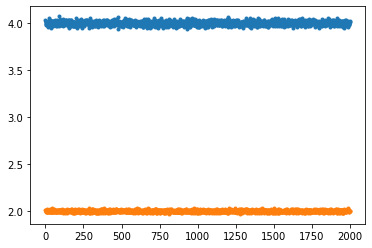

In [ ]:
import matplotlib.pyplot as plt

plt.plot( f, '.' )
plt.plot( g, '.' )
plt.show()

What is the consequence of uncertainty? 
We compare the cumulative lengths with the nominal ones.

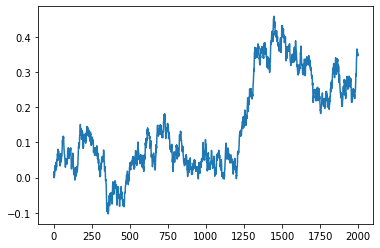

In [ ]:
cs = np.cumsum(g) - np.cumsum( [2]*len(g) )
plt.plot(cs)
plt.show()

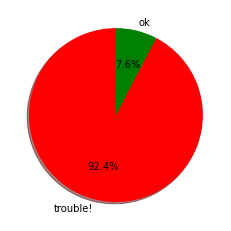

In [ ]:
plt.pie( [ sum( cs > 0 ), sum( cs <= 0 ) ], labels = [ 'trouble!', 'ok' ], autopct='%1.1f%%', shadow=True, startangle=90, colors=[ 'red', 'green' ])
plt.show()

A very simple and somehow naïf uncertainty region can be taken as the observed minimal box around the data.

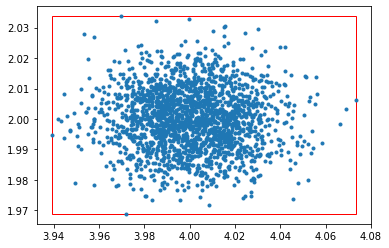

3.9391412319072394 4.073440566603856 1.9688647783939281 2.0337017720382375


In [ ]:
import matplotlib.patches as patches

plt.figure()
plt.plot( f, g, '.' )
currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle((min(f), min(g)), max(f)-min(f), max(g)-min(g),fill=False,color='r'))
plt.show()

print( min(f), max(f), min(g), max(g) )

## Caroline's robust model for box uncertainty in wood consumption

Suppose now that Alice notices that not _exactly_ 4 and 2 dm of wood are used, but some fluctuations are observed.
Alice wants to be __sure__ that her model does not violate the wood constraint, therefore the following should hold:

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & \leq & 4800 & \forall \ell \leq a \leq u \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

***

A bit of linear duality (or even better: an introduction to robust optimization!) helps Alice how to deal with the above model that has an infinite number of constraints.
The first thing to notice is that the wood consumption is modeled by constraints that are equivalent to bounding the following optimization problem:
    
$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & \ell \leq a \leq u 
\end{array}
$$

Or

$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & a \leq u \\
        & -a \leq -\ell 
\end{array}
$$

Now we use linear duality to realize that the above is equivalent to:
 
$$
\begin{array}{rrr}
\min    & u y  - \ell w & \leq 4800 \\
s.t.    & y - w = x \\
        & y \geq 0, w \geq 0
\end{array}
$$
    
and the constraint imposed by the last problem is equivalent to:

$$
\begin{array}{rrl}
   & u y  - \ell w & \leq 4800 \\
   & y - w & = x \\
   & y \geq 0, w \geq 0
\end{array}
$$

The only thing we need to do is add variables and constraints to Alice's model.

# A model in `pyomo`

In [ ]:
def AliceWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeReals ):

    Alice = pyo.ConcreteModel('AliceBox')

    Alice.x = pyo.Var(trophies,within=domain)

    Alice.profit    = pyo.Objective(expr = sum([profits[t]*Alice.x[t] for t in trophies]), sense=pyo.maximize)

    Alice.footballs = pyo.Constraint(expr = Alice.x['Football']  <= 1000)
    Alice.golfBalls = pyo.Constraint(expr = Alice.x['Golf']      <= 1500)
    Alice.plaques   = pyo.Constraint(expr = sum([Alice.x[t] for t in trophies]) <= 1750)

    Alice.y = pyo.Var(trophies,domain=pyo.NonNegativeReals)
    Alice.w = pyo.Var(trophies,domain=pyo.NonNegativeReals)

    Alice.robustWood = pyo.Constraint(expr = sum([upper[t]*Alice.y[t] - lower[t]*Alice.w[t] for t in trophies]) <= 4800)

    def PerVariable( model, t ):
        return model.x[t] == model.y[t] - model.w[t] 
    
    Alice.perVariable = pyo.Constraint(trophies,rule=PerVariable)

    return Alice

In [ ]:
lower = upper = {}
lower['Football'] = min(f)
upper['Football'] = max(f)
lower['Golf'] = min(g)
upper['Golf'] = max(g)

Alice = AliceWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeIntegers )

%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )

JustSolution( Alice )

CPU times: user 6.64 ms, sys: 7.2 ms, total: 13.8 ms
Wall time: 30.2 ms
ok optimal


[17574.0, 608.0, 1142.0]

In [ ]:
# you can play with the amount of uncertainty. 
# In particular, if below you make delta equal to 0 you obtain the same result als the  nominal model.
delta = 0.05

def AliceWithSymmetricalBoxUncertainty( delta, domain=pyo.NonNegativeIntegers ):
    lower = { trophy : wood[trophy] - delta for trophy in wood }
    upper = { trophy : wood[trophy] + delta for trophy in wood }
    return AliceWithBoxUncertainty( lower, upper, domain=domain )

Alice = AliceWithSymmetricalBoxUncertainty( delta )
%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )

JustSolution( Alice )

CPU times: user 2.77 ms, sys: 12.3 ms, total: 15 ms
Wall time: 29.8 ms
ok optimal


[17568.0, 606.0, 1144.0]

# Integer optimization

Alice's model gave integer solutions, but not the robust version. 
If we need integer solutions then we should impose that to the nature of the variables, which in this case of _box uncertainty_ is easy to do since the model remains linear, although it will be mixed integer. 

In [ ]:
Alice = AliceWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeIntegers )

%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )

JustSolution( Alice )

CPU times: user 8.89 ms, sys: 7.04 ms, total: 15.9 ms
Wall time: 40.9 ms
ok optimal


[17574.0, 608.0, 1142.0]

In [ ]:
import pandas
df = pandas.DataFrame()
for delta in np.linspace(0,.5,21):
  Alice = AliceWithSymmetricalBoxUncertainty( delta, domain=pyo.NonNegativeIntegers )
  cbc.solve(Alice)
  results = JustSolution( Alice )
  df.at[delta,'value']     = results[0]
  df.at[delta,trophies[0]] = results[1]
  df.at[delta,trophies[1]] = results[2]
df

,value,Football,Golf
0.000,17700.0,650.0,1100.0
0.025,17634.0,628.0,1122.0
0.050,17568.0,606.0,1144.0
0.075,17502.0,584.0,1166.0
0.100,17436.0,562.0,1188.0
0.125,17370.0,540.0,1210.0
0.150,17304.0,518.0,1232.0
0.175,17238.0,496.0,1254.0
0.200,17175.0,475.0,1275.0
0.225,17109.0,453.0,1297.0


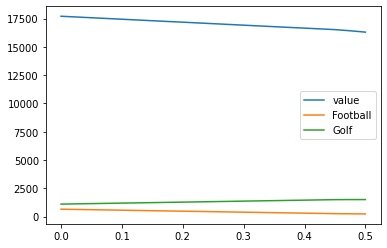

In [ ]:
df.plot()

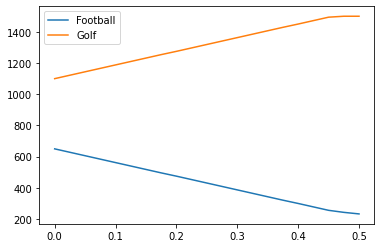

In [ ]:
df[['Football','Golf']].plot()

# Cardinality constrained uncertainty

Each $a_j$ may deviate by at most $\pm \delta_j$ from the nominal value $\bar{a}_j$ bun no more than $\Gamma$ will actually deviate.

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & \leq & 4800 & \forall a,y : a_j=\bar{a}_j+\delta_jy_j, \|y\|_\infty \leq 1, \|y\|_1\leq \Gamma \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

As we have seen on the previous lecture, Lagrange duality yields the following modification to the problem as equivalent to the robust model stated above:

$$
\begin{array}{rrcrcrcrcrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & & & & & & & \leq & 1000 \\
        &         &   &     x_2 & & & & & & & \leq & 1500 \\
        &     x_1 & + &     x_2 & & & & & & & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & + & \lambda\Gamma & + & z_1 & + & z_2 & \leq & 4800 \\
        &-d_1 x_1 &   &         & + & \lambda & + & z_1 &   &     & \geq & 0 \\
        &         &   &-d_2 x_2 & + & \lambda &   &     & + & z_2 & \geq & 0 \\
        &     x_1 & , &     x_2 & , & \lambda & , & z_1 & , & z_2 & \geq & 0    \\
\end{array}
$$

In [ ]:
def AliceWithGammaUncertainty( delta, gamma, domain=pyo.NonNegativeReals ):
    Alice = pyo.ConcreteModel('AliceGamma')

    Alice.x = pyo.Var(trophies,within=domain)

    Alice.profit    = pyo.Objective(expr = sum([profits[t]*Alice.x[t] for t in trophies]), sense=pyo.maximize)

    Alice.footballs = pyo.Constraint(expr = Alice.x['Football']  <= 1000)
    Alice.golfBalls = pyo.Constraint(expr = Alice.x['Golf']      <= 1500)
    Alice.plaques   = pyo.Constraint(expr = sum([Alice.x[t] for t in trophies]) <= 1750)

    Alice.z   = pyo.Var(trophies,domain=pyo.NonNegativeReals)
    Alice.lam = pyo.Var(domain=pyo.NonNegativeReals)

    Alice.robustWood = pyo.Constraint( \
     expr = sum([wood[t]*Alice.x[t] for t in trophies]) \
          + gamma * Alice.lam \
          + sum(Alice.z[t] for t in trophies) <= 4800)

    def up_rule( model, t ):
        return model.z[t] >=  delta * model.x[t] - model.lam
    def down_rule( model, t ):
        return model.z[t] >= -delta * model.x[t] - model.lam
    
    Alice.up   = pyo.Constraint(trophies,rule=up_rule)
    Alice.down = pyo.Constraint(trophies,rule=down_rule)

    return Alice

In [ ]:
Alice = AliceWithGammaUncertainty( 0.01, 2, domain=pyo.NonNegativeIntegers )

%time results = cbc.solve(Alice)
print(results.solver.status, results.solver.termination_condition )
JustSolution(Alice)

CPU times: user 8.1 ms, sys: 7.25 ms, total: 15.4 ms
Wall time: 34.7 ms
ok optimal


[17673.0, 641.0, 1109.0]

# Ball uncertainty

As [the documentation](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/conic.html) says a conic constraint is expressed in 'pyomo' in simple variables.

This [table](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/syntax_comparison.html) is very useful. 

A straightforward remodulation leads to that:

$$ 
  a_1x_1+a_2x_2 + \Omega \|x\| \leq 4800
$$

$$
  \Omega \|x\| \leq 4800 - a_1x_1 - a_2x_2
$$
$$
  \|\Omega x\| \leq 4800 - a_1x_1 - a_2x_2
$$

By defining $y = 4800 - a_1x_1 - a_2x_2$ we may write:
$$
  \Omega^2 \|x\|^2 \leq y^2
$$

$$
  (\Omega x_1)^2 + (\Omega x_2)^2 \leq y^2
$$

$$
  \|w\|^2 \leq y^2
$$

with $w = \Omega x$.

## Documentation says that we need to use the kernel now

In [ ]:
import pyomo.kernel as pyk

def AliceWithBallUncertainty( omega, domain_type=pyk.RealSet ):
    
    idxTrophies = range( len(trophies) )
    
    Alice = pyk.block()

    Alice.x = pyk.variable_list()
    for i in idxTrophies:
        Alice.x.append( pyk.variable(lb=0,domain_type=domain_type) )
    
    Alice.profit    = pyk.objective(expr = sum(profits[trophies[i]]*Alice.x[i] for i in idxTrophies), sense=pyk.maximize)

    Alice.footballs = pyk.constraint(expr = Alice.x[0]  <= 1000)
    Alice.golfBalls = pyk.constraint(expr = Alice.x[1]  <= 1500)
    Alice.plaques   = pyk.constraint(expr = sum([Alice.x[i] for i in idxTrophies]) <= 1750)

    Alice.y = pyk.variable(lb=0)
    Alice.w = pyk.variable_list()
    for i in idxTrophies:
        Alice.w.append( pyk.variable(lb=0) )

    Alice.wood = pyk.constraint( expr = Alice.y == 4800 - sum(wood[trophies[i]]*Alice.x[i] for i in idxTrophies) ) 

    Alice.xtow = pyk.constraint_list()
    for i in idxTrophies:
        Alice.xtow.append( pyk.constraint( expr = Alice.w[i] == omega * Alice.x[i] ) )

    from pyomo.core.kernel.conic import quadratic
    Alice.robust = quadratic(Alice.y,Alice.w)

    return Alice

## Now the problem is nonlinear

In [ ]:
Alice = AliceWithBallUncertainty( 0.1 )

%time results = ipopt.solve(Alice)
print(results.solver.status, results.solver.termination_condition )
print(pyk.value(Alice.profit))
print( [pyk.value(Alice.x[i]) for i in range(len(Alice.x))] )

CPU times: user 7.34 ms, sys: 6.25 ms, total: 13.6 ms
Wall time: 30.8 ms
ok optimal
17504.443278691946
[584.814373731946, 1165.1856437676215]


## But `cplex`, `gurobi` and `xpress` support second order cones

In [ ]:
conicsolver = gurobi

In [ ]:
%time results = conicsolver.solve(Alice)
print(results.solver.status, results.solver.termination_condition )
print(pyk.value(Alice.profit))
print( [pyk.value(Alice.x[i]) for i in range(len(Alice.x))] )

CPU times: user 6.56 ms, sys: 919 µs, total: 7.48 ms
Wall time: 8.23 ms
ok optimal
17504.443176720328
[584.8143922330063, 1165.1856077693617]


## And therefore we can also have mixed integer models 

In [ ]:
Alice = AliceWithBallUncertainty( 0.1, domain_type=pyk.IntegerSet )

%time results = conicsolver.solve(Alice)
print(results.solver.status, results.solver.termination_condition )
print(pyk.value(Alice.profit))
print( [pyk.value(Alice.x[i]) for i in range(len(Alice.x))] )

CPU times: user 4.97 ms, sys: 1 ms, total: 5.97 ms
Wall time: 6.47 ms
ok optimal
17502.0
[584.0, 1166.0]


## Final note: maybe useful to recall that in python you can always ask for help...

In [ ]:
help(Alice.y)

Help on variable in module pyomo.core.kernel.variable object:

class variable(IVariable)
 |  variable(domain_type=None, domain=None, lb=None, ub=None, value=None, fixed=False)
 |  
 |  A decision variable
 |  
 |  Decision variables are used in objectives and
 |  constraints to define an optimization problem.
 |  
 |  Args:
 |      domain_type: Sets the domain type of the
 |          variable. Must be one of :const:`RealSet` or
 |          :const:`IntegerSet`. Can be updated later by
 |          assigning to the :attr:`domain_type`
 |          property. The default value of :const:`None` is
 |          equivalent to :const:`RealSet`, unless the
 |          :attr:`domain` keyword is used.
 |      domain: Sets the domain of the variable. This
 |          updates the :attr:`domain_type`, :attr:`lb`, and
 |          :attr:`ub` properties of the variable. The
 |          default value of :const:`None` implies that this
 |          keyword is ignored. This keyword can not be used
 |         

In [ ]:
help(Alice.robust)

Help on quadratic in module pyomo.core.kernel.conic object:

class quadratic(_ConicBase)
 |  quadratic(r, x)
 |  
 |  A quadratic conic constraint of the form:
 |  
 |      x[0]^2 + ... + x[n-1]^2 <= r^2,
 |  
 |  which is recognized as convex for r >= 0.
 |  
 |  Parameters
 |  ----------
 |  r : :class:`variable`
 |      A variable.
 |  x : list[:class:`variable`]
 |      An iterable of variables.
 |  
 |  Method resolution order:
 |      quadratic
 |      _ConicBase
 |      pyomo.core.kernel.constraint.IConstraint
 |      pyomo.core.kernel.base.ICategorizedObject
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, r, x)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  check_convexity_conditions(self, relax=False)
 |      Returns True if all convexity conditions for the
 |      conic constraint are satisfied. If relax is True,
 |      then variable domains are ignored and it is assumed
 |      that all variables are continuous

# How to bring second order cones into the `pyomo.environ`

Noting that $\| x \| \leq t$ is for $t \geq 0$ equivalent to $\| x \|^2 \leq t^2$ and knowing that the commercial solvers (`gurobi`, `cplex` and `express`) support convex quadratic inequalities, we can model this variant in `pyomo.environ` as follows.

Note that the essential part to make the model convex is having the rght hand side nonnegative.

In [ ]:
def AliceWithBallUncertaintyAsSquaredSecondOrderCone(omega,domain=pyo.NonNegativeReals):
  Alice = pyo.ConcreteModel('Alice')

  Alice.x = pyo.Var(trophies,within=domain)

  # the nonegativity of this variable is essential!
  Alice.y = pyo.Var(within=pyo.NonNegativeReals)

  Alice.profit    = pyo.Objective(expr = sum([profits[t]*Alice.x[t] for t in trophies]), sense=pyo.maximize)

  Alice.footballs = pyo.Constraint(expr = Alice.x['Football']  <= 1000)
  Alice.golfBalls = pyo.Constraint(expr = Alice.x['Golf']      <= 1500)
  Alice.plaques   = pyo.Constraint(expr = sum([Alice.x[t] for t in trophies]) <= 1750)
  Alice.wood      = pyo.Constraint(expr = Alice.y == 4800 - sum(wood[t]*Alice.x[t] for t in trophies) ) 
  Alice.robust    = pyo.Constraint(expr = sum((omega*Alice.x[t])**2 for t in trophies) <= Alice.y**2) 
  return Alice

In [ ]:
Alice = AliceWithBallUncertaintyAsSquaredSecondOrderCone( 0.1, domain=pyo.NonNegativeIntegers )

%time results = cplex.solve(Alice)
print(results.solver.status, results.solver.termination_condition )
JustSolution(Alice)

CPU times: user 7.48 ms, sys: 1.94 ms, total: 9.42 ms
Wall time: 9.67 ms
ok optimal


[17502.0, 584.0, 1166.0]

Note how the verbose `xpress` solver confirms that the convex quadratic constraint is recognized as conic.

In [ ]:
Alice = AliceWithBallUncertaintyAsSquaredSecondOrderCone( 0.1, domain=pyo.NonNegativeIntegers )

%time results = xpress.solve(Alice,tee=True)
print(results.solver.status, results.solver.termination_condition )
JustSolution(Alice)

FICO Xpress v8.12.3, Community, solve started 13:48:08, Oct 5, 2021
Heap usage: 339KB (peak 339KB, 428KB system)
Maximizing MIQCQP Alice with these control settings:
OUTPUTLOG = 1
Original problem has:
         5 rows            3 cols            7 elements         2 globals
         1 qrows           3 qrowelem
Converted 1 second order cones to standard form
Presolved problem has:
         7 rows            7 cols           12 elements         2 globals
         2 cones           4 celems
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 369KB (peak 387KB, 430KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  4.00e+00] / [ 1.00e-01,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+03,  4.80e+03] / [ 1.00e+02,  4.80e+03]
  Objective      [min,max] : [ 9.00e+00,  1.20e+01] / [ 9.00e+00,  1.20e+01]
  Quadratic      [min,max] : [ 2.00e-02,  2.00e+00] / [ 2.00e+00,  2.00e+00]
Autoscaling applied

[17502.0, 584.0, 1166.0]